## 5. Modelling and generating template libraries for smaller regions withing a FOV using the GALACTICNUCLEUS catalogue


In Notebook 2, it was shown the it is not fleasible to generate libraries for different stellar populations for the entire FOV (here we are refering to 1.2' as the FOV) and the entire catalogue has over two hundred thousand stars. The aim of this notebook is to see if we can narrow down this problem by further dividing the FOV into sub-grids and fixing the scale of the problem. 

The notebook is divided into the following sections:
1. Defining Input Parameters
2. Division of FOV
3. Generation of the template library


Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine Neumayer and Francisco Nogueras-Lara (MPIA)** <br/>
Date: **09th November 2020** <br/>

In [79]:
import astropy.units as u
import astropy.io.fits as fits

from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

# to show progress during computations
from time import sleep
import sys

import matplotlib
import seaborn as sns

# for manupilating spectra
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from specutils import Spectrum1D

# for doing combinatorics with spectra
from itertools import permutations

In [80]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [81]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm
import star_by_star_template_library as stl

#### 1. Defining Input Parameters

In [85]:
l_pix, u_pix = 0, 2000
generate_new_pos = False
x_pos, y_pos, mag_H, mag_Ks = np.load('Data/selected_FOV.npy')
selected_c_pxls = np.load('Data/selected_central_pixels.npy')
num_stars = len(mag_Ks)

template_dir = 'Data/Template_library_%d_stars/'%num_stars
hot_stars = 0.1
templates_exist = False

# wavelength to pixel conversions
delta_lambda = 0.0005  # micro meter ==  1 pixel
k_band_lambda0 = 2.2
k_band_range = 0.3 # micro meter

# set the dispersion range of the spectra
disperse_range = ss.defineDispersionRange(r=4000, lambda0=2.2, band_width=0.4)
print('The size of dispersion is set to be %d pixels'%disperse_range)

dispersion_angle = 0 # degrees

# width of influence of the PSF on neighbouring stars
width=3

# number to which the dimensions of the original image is reduced to cal chi-squared
num_splits = int(u_pix/5)

# different populations of hot stars considered 
hot_stars_arr = np.arange(1, 10)/10

The size of dispersion is set to be 727 pixels


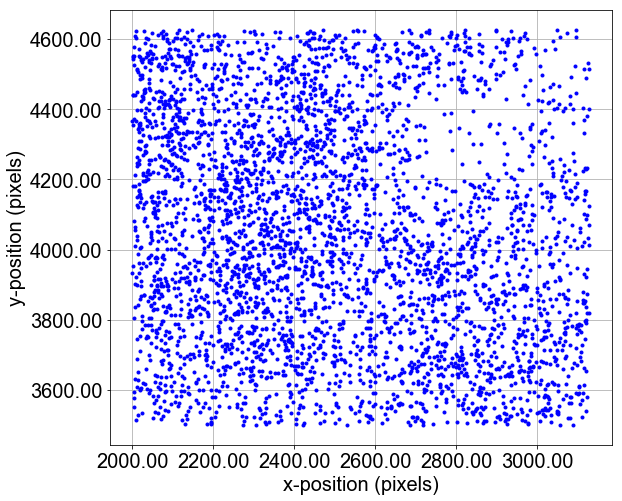

In [84]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

# plotting the stars
ax.plot(x_pos, y_pos, "b.")
pt.setLabel(ax, 'x-position (pixels)', 'y-position (pixels)', '', 'default', 'default', legend=False)

pt.shortenXYaxisTicks(ax)

#### 2. Select a star in the FOV and reduce FOV to a sub-grid

In [88]:
star_neighbours, num_neighbours = stl.findStarAndNeighbours(x_pos, y_pos, mag_H, mag_Ks, disperse_range, width, selected_c_pxls)

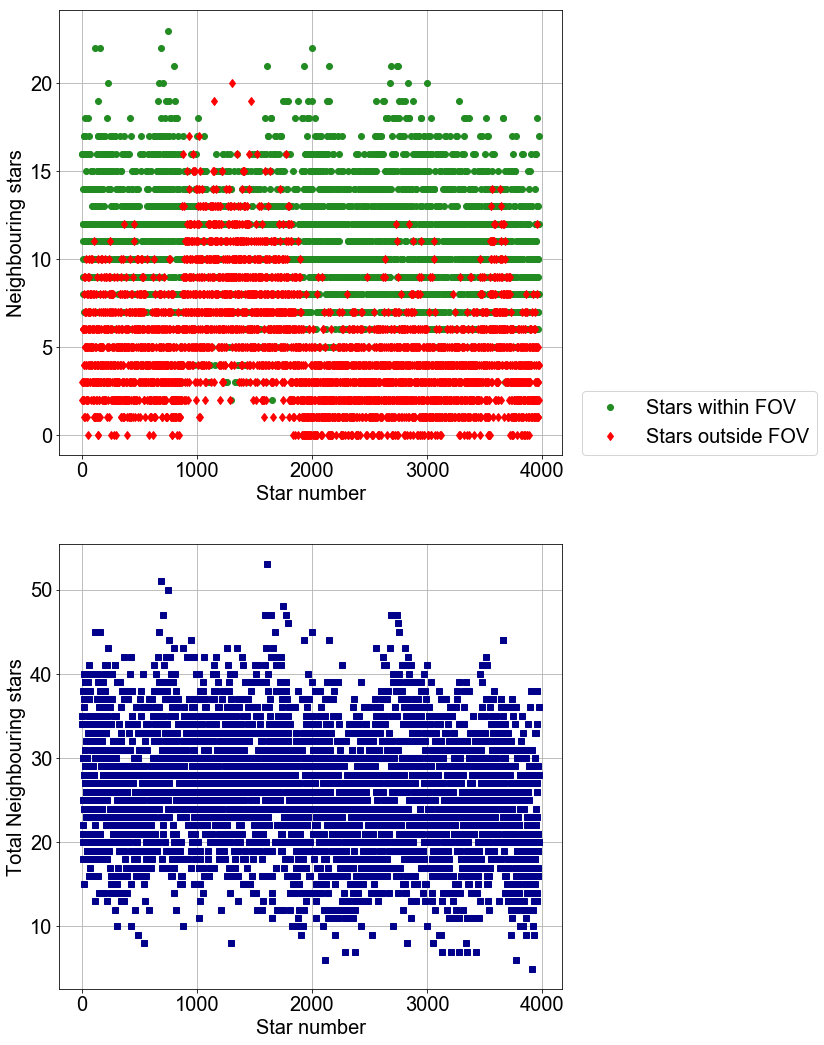

In [89]:
fig, ax = plt.subplots(2,1,figsize=(9,18))

# plotting the stars
ax[0].plot(np.arange(1, len(x_pos)+1), num_neighbours[0], 'o', color="ForestGreen", label='Stars within FOV')
ax[0].plot(np.arange(1, len(x_pos)+1), np.array(num_neighbours[1])-np.array(num_neighbours[0]), 'd', color="red", label='Stars outside FOV')

pt.setLabel(ax[0], 'Star number', 'Neighbouring stars', '', 'default', 'default', legend=True)

ax[1].plot(np.arange(1, len(x_pos)+1), np.array(num_neighbours[1])+np.array(num_neighbours[0]), 's', color="DarkBlue")

pt.setLabel(ax[1], 'Star number', 'Total Neighbouring stars', '', 'default', 'default', legend=False)

Number of neighbouring stars in FOV: 16
Number of neighbouring stars outside FOV: 18


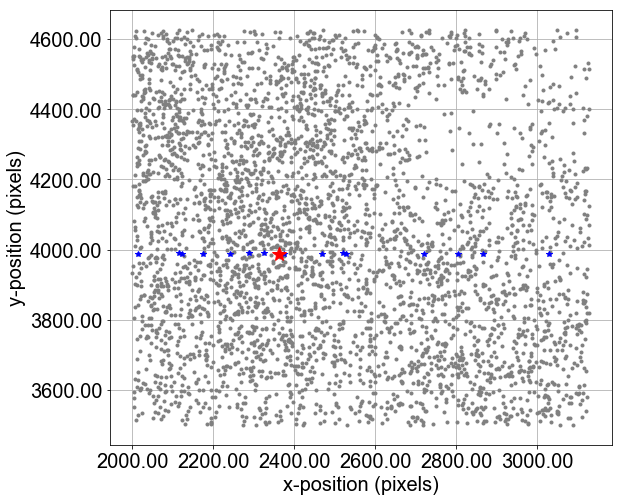

In [102]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

idx = 0
# plotting the stars
ax.plot(x_pos, y_pos, '.', color="grey")
ax.plot(star_neighbours[0][idx][0],star_neighbours[0][idx][1], "b*")
ax.plot(x_pos[idx], y_pos[idx], 'r*', markersize=15)
pt.setLabel(ax, 'x-position (pixels)', 'y-position (pixels)', '', 'default', 'default', legend=False)

print('Number of neighbouring stars in FOV:', len(star_neighbours[0][idx][0]))
print('Number of neighbouring stars outside FOV:', len(star_neighbours[1][idx][0]))
pt.shortenXYaxisTicks(ax)